Convert image to 2D matrix

In [62]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

def load_images(image_paths, image_size=None, normalize=True):
    """
    Load images, convert them to grayscale, resize if necessary, and normalize pixel values.

    Parameters:
        image_paths (list): List of paths to image files.
        image_size (tuple): Desired image size as (width, height). If None, use original size.
        normalize (bool): Whether to normalize pixel values to [0, 1].

    Returns:
        data_matrix (numpy.ndarray): 2D array with shape (num_images, num_pixels).
        img_shape (tuple): Shape of each image.
    """
    images = []
    for path in image_paths:
        img = Image.open(path).convert('L')  # Convert to grayscale
        if image_size:
            img = img.resize(image_size)
        img_array = np.array(img, dtype=np.float32).flatten()
        if normalize:
            img_array /= 255.0  # Normalize pixel values to [0, 1]
        images.append(img_array)
    
    data_matrix = np.array(images)
    if image_size:
        img_shape = image_size
    else:
        img_shape = img.size  # Original size if not resized
    return data_matrix, img_shape

# Example usage:
# Assuming you have a directory 'images/' with grayscale images of the same size
image_dir = 'cropped_faces/'  # Replace with your image directory
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) 
              if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')) and fname.lower().startswith("cropped_face")]

# Load images and resize them to 64x64 pixels for consistency, with normalization
data_matrix, img_shape = load_images(image_paths, image_size=(64, 64), normalize=True)
print(f"Data matrix shape: {data_matrix.shape}")
print(f"Pixel value range after normalization: [{data_matrix.min()}, {data_matrix.max()}]")


Data matrix shape: (21, 4096)
Pixel value range after normalization: [0.0, 1.0]


Compute co-variance matrix

In [63]:
def compute_covariance_matrix(data):
    """
    Compute the covariance matrix of the data.
    
    Parameters:
        data (numpy.ndarray): 2D array with shape (num_samples, num_features).
        
    Returns:
        covariance_matrix (numpy.ndarray): Covariance matrix with shape (num_features, num_features).
        mean_image (numpy.ndarray): Mean of the data.
    """
    # Center the data by subtracting the mean
    mean_image = np.mean(data, axis=0)
    centered_data = data - mean_image
    
    # Compute covariance matrix
    covariance_matrix = np.cov(centered_data, rowvar=False)
    return covariance_matrix, mean_image

# Example usage:
cov_matrix, mean_image = compute_covariance_matrix(data_matrix)
print(f"Covariance matrix shape: {cov_matrix.shape}")


Covariance matrix shape: (4096, 4096)


Calculate Eigen-values and Egenvectors

In [64]:
def compute_eigen(covariance_matrix):
    """
    Compute eigenvalues and eigenvectors of the covariance matrix.
    
    Parameters:
        covariance_matrix (numpy.ndarray): Covariance matrix.
        
    Returns:
        eigenvalues (numpy.ndarray): Eigenvalues.
        eigenvectors (numpy.ndarray): Eigenvectors.
    """
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    return eigenvalues, eigenvectors

# Example usage:
eigenvalues, eigenvectors = compute_eigen(cov_matrix)
print(f"Number of eigenvalues: {len(eigenvalues)}")


Number of eigenvalues: 4096


Sort Eigenvectors Based on Eigenvalues in Descending Order

In [65]:
def sort_eigen(eigenvalues, eigenvectors):
    """
    Sort eigenvectors based on eigenvalues in descending order.
    
    Parameters:
        eigenvalues (numpy.ndarray): Eigenvalues.
        eigenvectors (numpy.ndarray): Eigenvectors.
        
    Returns:
        sorted_eigenvalues (numpy.ndarray): Sorted eigenvalues.
        sorted_eigenvectors (numpy.ndarray): Sorted eigenvectors.
    """
    sorted_idx = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_idx]
    sorted_eigenvectors = eigenvectors[:, sorted_idx]
    return sorted_eigenvalues, sorted_eigenvectors

# Example usage:
sorted_eigenvalues, sorted_eigenvectors = sort_eigen(eigenvalues, eigenvectors)
print(f"Top 5 eigenvalues: {sorted_eigenvalues[:5]}")


Top 5 eigenvalues: [53.96335765 40.53610127 25.33148015 18.64183765 17.4004812 ]


Select the Top k Eigenvectors to Form Principal Components

In [66]:
def select_top_k(sorted_eigenvectors, k):
    """
    Select the top k eigenvectors.
    
    Parameters:
        sorted_eigenvectors (numpy.ndarray): Eigenvectors sorted by eigenvalues.
        k (int): Number of top eigenvectors to select.
        
    Returns:
        principal_components (numpy.ndarray): Top k eigenvectors.
    """
    principal_components = sorted_eigenvectors[:, :k]
    return principal_components

# Example usage:
k = 50  # Number of principal components
principal_components = select_top_k(sorted_eigenvectors, k)
print(f"Principal components shape: {principal_components.shape}")


Principal components shape: (4096, 50)


Project Original Images onto Lower-Dimensional Subspace

In [67]:
def project_data(data, mean, principal_components):
    """
    Project data onto principal components.
    
    Parameters:
        data (numpy.ndarray): Original data matrix.
        mean (numpy.ndarray): Mean image.
        principal_components (numpy.ndarray): Principal components.
        
    Returns:
        projected_data (numpy.ndarray): Lower-dimensional representation.
    """
    centered_data = data - mean
    projected_data = np.dot(centered_data, principal_components)
    return projected_data

# Example usage:
projected_data = project_data(data_matrix, mean_image, principal_components)
print(f"Projected data shape: {projected_data.shape}")


Projected data shape: (21, 50)


Reconstruct Images Using Principal Components

In [68]:
def reconstruct_data(projected_data, principal_components, mean):
    """
    Reconstruct data from its lower-dimensional representation.
    
    Parameters:
        projected_data (numpy.ndarray): Lower-dimensional data.
        principal_components (numpy.ndarray): Principal components.
        mean (numpy.ndarray): Mean image.
        
    Returns:
        reconstructed_data (numpy.ndarray): Reconstructed data matrix.
    """
    reconstructed_data = np.dot(projected_data, principal_components.T) + mean
    return reconstructed_data

# Example usage:
reconstructed_data = reconstruct_data(projected_data, principal_components, mean_image)
print(f"Reconstructed data shape: {reconstructed_data.shape}")


Reconstructed data shape: (21, 4096)


Compare Reconstructed Images with Original Images

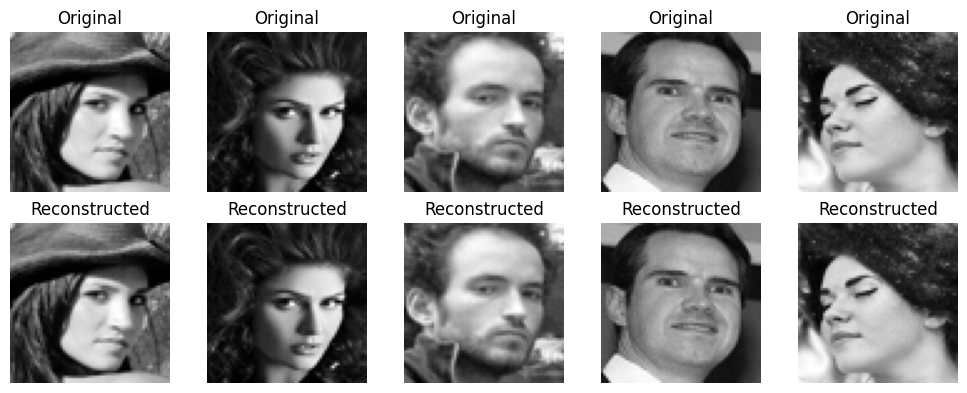

In [69]:
def display_original_and_reconstructed(original, reconstructed, img_shape, num_images=5):
    """
    Display original and reconstructed images side by side.
    
    Parameters:
        original (numpy.ndarray): Original data matrix.
        reconstructed (numpy.ndarray): Reconstructed data matrix.
        img_shape (tuple): Shape of each image.
        num_images (int): Number of images to display.
    """
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(img_shape), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # Reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(img_shape), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
display_original_and_reconstructed(data_matrix, reconstructed_data, img_shape, num_images=5)


Vary the Number of Principal Components (k) and Observe Reconstruction Quality

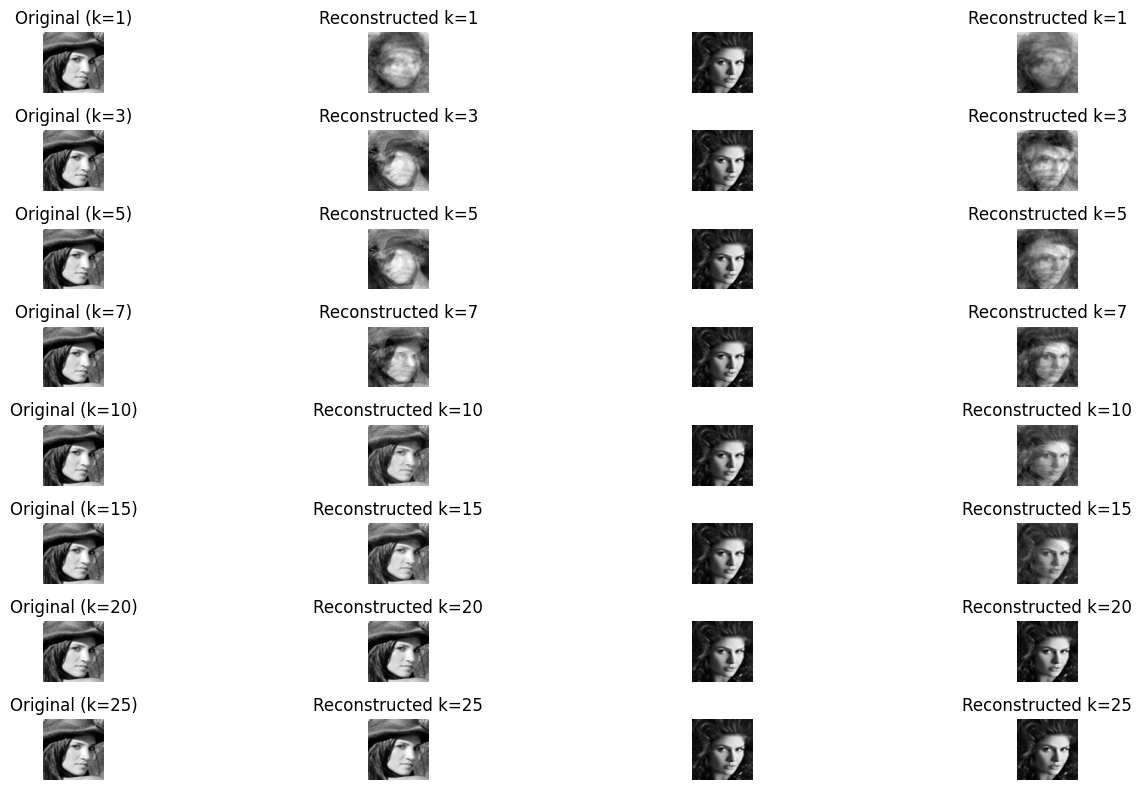

In [70]:
def experiment_with_k(image_paths, image_size=(64,64), ks=[10, 50, 100, 200]):
    data_matrix, img_shape = load_images(image_paths, image_size=image_size)
    cov_matrix, mean_image = compute_covariance_matrix(data_matrix)
    eigenvalues, eigenvectors = compute_eigen(cov_matrix)
    sorted_eigenvalues, sorted_eigenvectors = sort_eigen(eigenvalues, eigenvectors)
    
    plt.figure(figsize=(15, 8))
    num_images = 2
    for idx, k in enumerate(ks):
        principal_components = select_top_k(sorted_eigenvectors, k)
        projected_data = project_data(data_matrix, mean_image, principal_components)
        reconstructed_data = reconstruct_data(projected_data, principal_components, mean_image)
        
        for i in range(num_images):
            plt.subplot(len(ks), num_images*2, idx*num_images*2 + i*2 + 1)
            plt.imshow(data_matrix[i].reshape(img_shape), cmap='gray')
            if i == 0:
                plt.title(f"Original (k={k})")
            plt.axis('off')
            
            plt.subplot(len(ks), num_images*2, idx*num_images*2 + i*2 + 2)
            plt.imshow(reconstructed_data[i].reshape(img_shape), cmap='gray')
            plt.title(f"Reconstructed k={k}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
experiment_with_k(image_paths, image_size=(64,64), ks=[1, 3, 5, 7, 10, 15, 20, 25])


Plot the Variance Explained by Principal Components

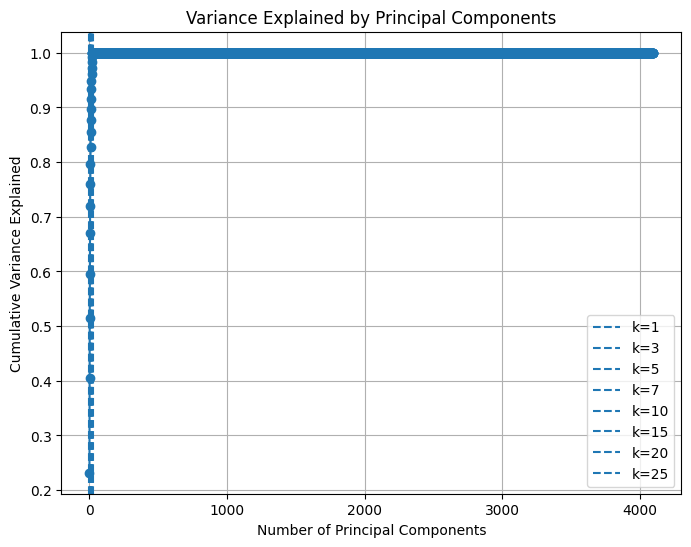

In [71]:
def plot_variance_explained(eigenvalues, ks=None):
    """
    Plot cumulative variance explained by principal components.
    
    Parameters:
        eigenvalues (numpy.ndarray): Sorted eigenvalues in descending order.
        ks (list or None): Specific k values to highlight. If None, plot all.
    """
    total_variance = np.sum(eigenvalues)
    variance_explained = np.cumsum(eigenvalues) / total_variance

    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(variance_explained)+1), variance_explained, marker='o', linestyle='-')
    if ks:
        for k in ks:
            plt.axvline(x=k, linestyle='--', label=f'k={k}')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Variance Explained by Principal Components')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_variance_explained(sorted_eigenvalues, ks=[1, 3, 5, 7, 10, 15, 20, 25])


Display Original and Reconstructed Images for Different k Values

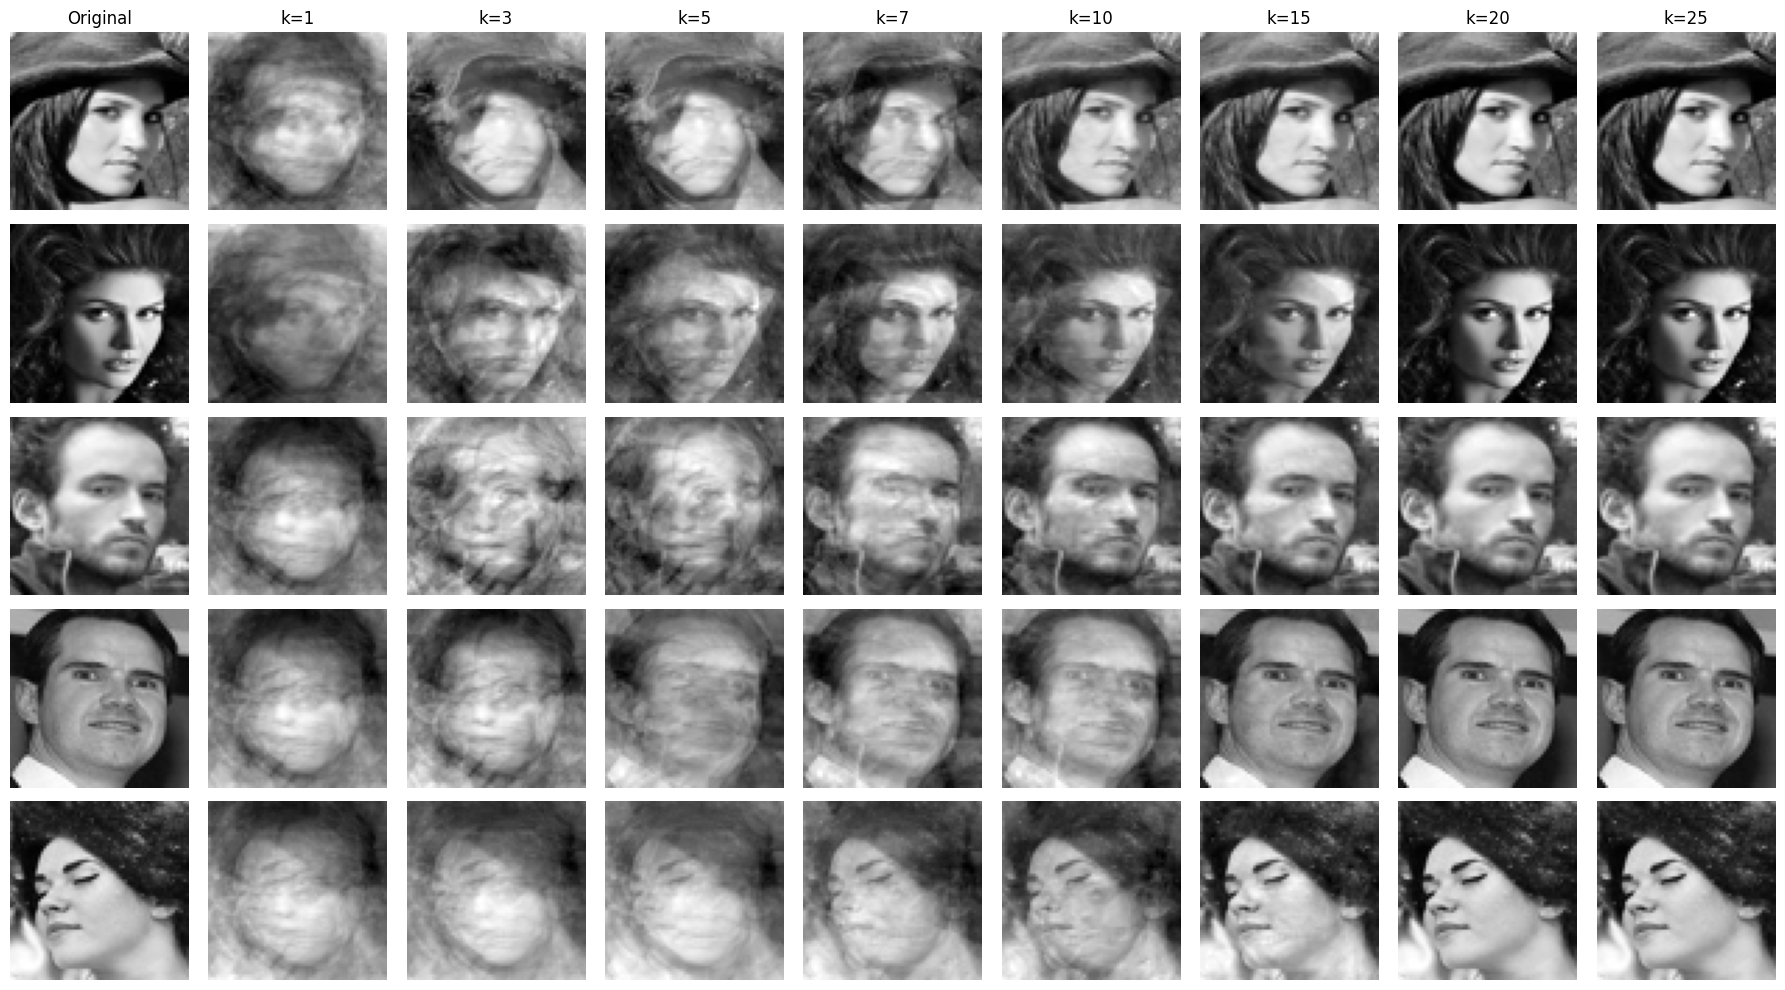

In [72]:
def display_reconstructions_for_different_k(original, mean, sorted_eigenvectors, ks, img_shape, num_images=5):
    """
    Display original and reconstructed images for different k.
    
    Parameters:
        original (numpy.ndarray): Original data matrix.
        mean (numpy.ndarray): Mean image.
        sorted_eigenvectors (numpy.ndarray): Sorted eigenvectors.
        ks (list): List of k values.
        img_shape (tuple): Shape of each image.
        num_images (int): Number of images to display.
    """
    num_ks = len(ks)
    plt.figure(figsize=(num_ks*2 + 2, num_images*2))
    for i in range(num_images):
        # Display original image
        plt.subplot(num_images, num_ks +1, i*(num_ks +1) +1)
        plt.imshow(original[i].reshape(img_shape), cmap='gray')
        if i ==0:
            plt.title("Original")
        plt.axis('off')
        
        for j, k in enumerate(ks):
            principal_components = sorted_eigenvectors[:, :k]
            projected_data = np.dot(original[i] - mean, principal_components)
            reconstructed = np.dot(projected_data, principal_components.T) + mean
            plt.subplot(num_images, num_ks +1, i*(num_ks +1) + j +2)
            plt.imshow(reconstructed.reshape(img_shape), cmap='gray')
            if i ==0:
                plt.title(f"k={k}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
display_reconstructions_for_different_k(data_matrix, mean_image, sorted_eigenvectors, 
                                        ks=[1, 3, 5, 7, 10, 15, 20, 25], img_shape=img_shape, num_images=5)


Compute the Mean Squared Error (MSE) Between Original and Reconstructed Images

In [73]:
def compute_mse(original, reconstructed):
    """
    Compute the Mean Squared Error between original and reconstructed data.
    
    Parameters:
        original (numpy.ndarray): Original data matrix.
        reconstructed (numpy.ndarray): Reconstructed data matrix.
        
    Returns:
        mse (float): Mean Squared Error.
    """
    mse = np.mean((original - reconstructed) **2)
    return mse

# Example usage:
mse = compute_mse(data_matrix, reconstructed_data)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 8.872198319905789e-16


Analyze the Trade-off Between Compression and Reconstruction Error

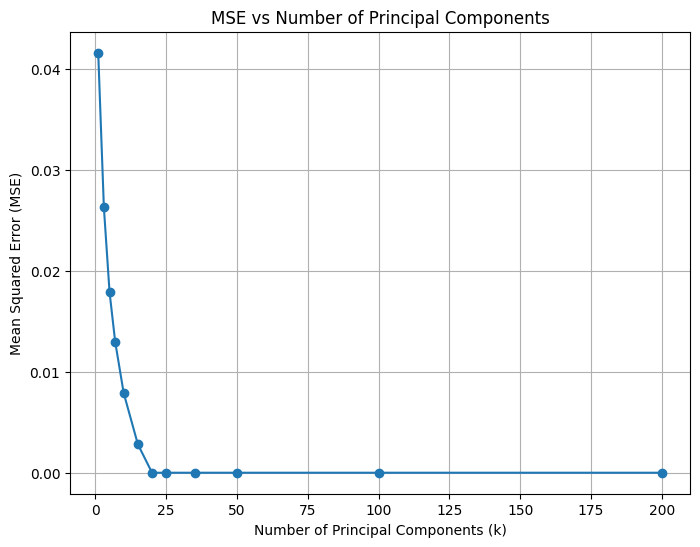

k=1, MSE=0.041591162772192894
k=3, MSE=0.0262759700739995
k=5, MSE=0.017895594692225843
k=7, MSE=0.012954004011706974
k=10, MSE=0.00788717426440541
k=15, MSE=0.0028158256976622905
k=20, MSE=8.916535477167452e-16
k=25, MSE=8.911398464203888e-16
k=35, MSE=8.883650017659718e-16
k=50, MSE=8.872198319905789e-16
k=100, MSE=8.766649783549123e-16
k=200, MSE=8.576774284611437e-16


In [74]:
def plot_mse_vs_k(image_paths, image_size=(64,64), ks=[10, 50, 100, 200]):
    data_matrix, img_shape = load_images(image_paths, image_size=image_size)
    cov_matrix, mean_image = compute_covariance_matrix(data_matrix)
    eigenvalues, eigenvectors = compute_eigen(cov_matrix)
    sorted_eigenvalues, sorted_eigenvectors = sort_eigen(eigenvalues, eigenvectors)
    
    mses = []
    for k in ks:
        principal_components = select_top_k(sorted_eigenvectors, k)
        projected_data = project_data(data_matrix, mean_image, principal_components)
        reconstructed_data = reconstruct_data(projected_data, principal_components, mean_image)
        mse = compute_mse(data_matrix, reconstructed_data)
        mses.append(mse)
    
    plt.figure(figsize=(8,6))
    plt.plot(ks, mses, marker='o')
    plt.xlabel('Number of Principal Components (k)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE vs Number of Principal Components')
    plt.grid(True)
    plt.show()
    
    for k, mse in zip(ks, mses):
        print(f"k={k}, MSE={mse}")

# Example usage:
plot_mse_vs_k(image_paths, image_size=(64,64), ks=[1, 3, 5, 7, 10, 15, 20, 25, 35, 50, 100, 200])
